In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/tom/coding/ExTRApack/')
import ExTRA as ex

ExTRA correctly imported


# HIP Mockdata

In [ ]:
#The gaia standard model solution can usually be read of online.
#However
#For the purpose of showing, here is just a simple example:

#model used in mockdata.ipynb:
asc=20
dec=-10
parallax=200
mu_a_star=-100
mu_d=+300


gaia=np.array([asc,dec,parallax,mu_a_star,mu_d])

J2016=2457389.0
J1991=2448349.0625


#Assuming hip and gaia got the same solution:

hip_standard=np.zeros(5)


hip_standard[0],hip_standard[1]=ex.pos_recalc(*[asc,dec,mu_a_star,mu_d],J2016,J1991)
#hip standard epoch is J1991


hip_standard[2:5]=np.array(gaia[2:5])

print(hip_standard)

[  20.00082507  -10.0020625   200.         -100.          300.        ]


In [3]:
HIP=ex.hip_read("mock_HIP.txt")
hip_ad=HIP[0] #A3,A4,A5,A6,A7,A8,A9=HIP[0] this is needed for fitting !!!


A3,A4,A5,A6,A7,A8,A9=HIP[0] 
t_hip=HIP[1] #time of measurements in JD, for plots

# RV Mockdata

In [4]:
RV_data=ex.RV_read("mock_RV.txt")
t_RV,RV,RV_err=RV_data #timestamps,RVs,error

## Working with the data

### 1) Plotting HIP data

In [5]:
x,x_err,y,y_err=ex.hip_2d(hip_ad) #Rotates the HIP measurements into the RA,Dec frame.

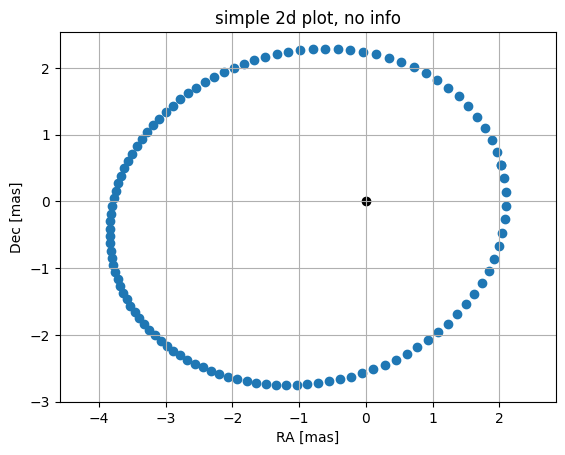

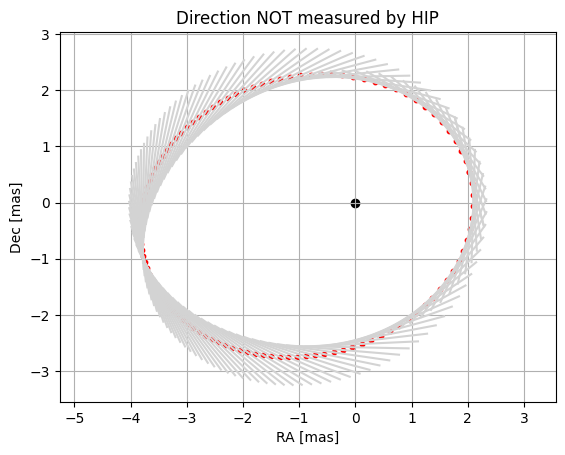

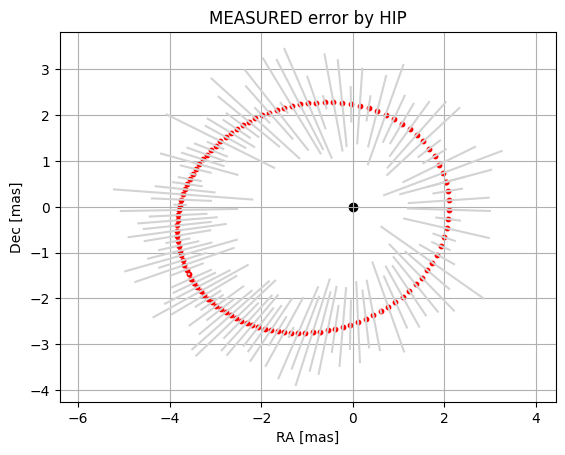

In [6]:
plt.title("simple 2d plot, no info")
plt.scatter(x,y)
plt.scatter(0,0,color="k")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.axis("equal")
plt.grid()
plt.show()



ex.plot_hip(x,x_err,y,y_err)

plt.title("Direction NOT measured by HIP")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.scatter(0,0,color="k")
plt.axis("equal")
plt.grid()
plt.show()




ex.plot_hip_err(x,x_err,y,y_err,s=10)

plt.title("MEASURED error by HIP")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.scatter(0,0,color="k")
plt.axis("equal")
plt.grid()
plt.show()


### 2) Fitting 

#### 2.1) just HIP (important for Trifon)

In [7]:
#For simplicity i assume gaia and HIP to have the same exact solution, but usually the gaia solution is different from the HIP
#solution and way more accurate
#standard epochs
J1991=2448349.0 #1991.25
J2000=2451545.0
J2016=2457389.0


In [8]:
#Parameters #taken from the datawrite file
correction=np.array([0,0,0,0,0])

P=550
e=0.3
om=np.radians(0)
i=np.radians(30)
Om=np.radians(75)
T0=J1991+900 #900 days after standard 1991
a=3

In [9]:
ex.L_hip(hip_ad,hip_standard,gaia, #Data
         correction,P,e,om,i,Om,T0,a, #parameters
         s_hip=0)#jitter

35.03124349196196